In [1]:
import pandas as pd 
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import datetime
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import re
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from collections import Counter
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
from PIL import Image
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import VotingClassifier
from IPython.core.pylabtools import figsize
from sklearn.svm import SVC  
from sklearn.naive_bayes import GaussianNB
from itertools import combinations
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output
from IPython.display import Image 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Hillary Clinton and Donald Trump Tweets

**Twitter has played an increasingly prominent role in the 2016 US Presidential Election. Debates have raged and candidates have risen and fallen based on tweets.
The dataset provides recent tweets from Hillary Clinton and Donald Trump, the two major-party presidential nominees.** 

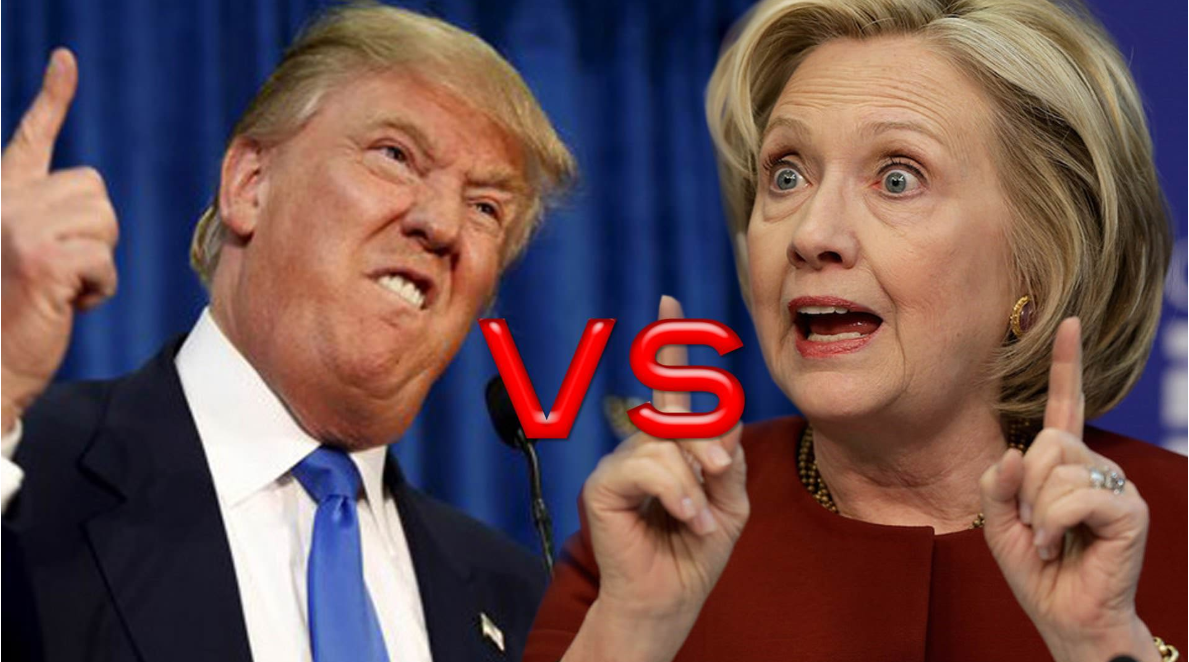

In [2]:
Image(filename='TrumpClinton.png')

# Problem Statement

### Predicting who tweeted  it: Trump or Clinton???


**Work Flow**
1. Reading the Dataset
2. Data cleaning
3. Handling imbalanced data
4. Feature Engineering+Exploratory data analysis
5. Word Cloud
6. Establish a baseline
7. compare several machine learning models with different transformations/manipulations<br>    7.1 CountVectorizer<br>
   7.2 Trying to improve the models with data cleaning/formating (Stemming,removing punctuation,removing stop words)<br>
   7.3 Trying to improve the models with td-idf transformation<br>
8. Compare several "combined" algorithms from best scores
9. Make some hyperparameter tuning from best model.
10. Create my own algorithm from best score.
11. Create guess game

# The Data 


 * **ClintonTrumpTweets.csv**- Hillary Clinton and Donald Trump Tweets Data  <br> https://www.kaggle.com/benhamner/clinton-trump-tweets

## Reading the Dataset

Columns  we read:
* **handle**- Tweet writer (TRUMP,CLINTON)-->Target
* **text**- Tweet text
* **time**- Tweet time
* **lang**- Tweet language (for filtering)

In [3]:
tweets= pd.read_csv('ClintonTrumpTweets.csv',parse_dates=['time'],usecols=["handle","text","time","lang"])


# Data Cleaning


#### Removing non english tweets records <br> 


In [4]:
tweets.isna().sum()

handle    0
text      0
time      0
lang      0
dtype: int64

In [5]:
tweets.groupby(['lang']).size()

lang
da        3
en     6248
es      105
et        1
fi        1
fr        2
tl        2
und      82
dtype: int64

In [6]:
tweets=tweets[tweets["lang"]=="en"]

In [7]:
tweets=tweets.drop(["lang"], axis=1)

In [8]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6248 entries, 0 to 6443
Data columns (total 3 columns):
handle    6248 non-null object
text      6248 non-null object
time      6248 non-null datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 195.2+ KB


In [9]:
tweets.groupby(['handle']).size()

handle
HillaryClinton     3117
realDonaldTrump    3131
dtype: int64

# Handling imbalanced data


We see that the predicted feature are pretty balanced.

For this classification I balanced that data so exactly half of data will be records where TRUMP is the tweeter and half of the data CLINTON is the tweeter
In this case the model should give accuracy better than 50% to say the model is usefull 

In [10]:
tweets.groupby(['handle']).size()

handle
HillaryClinton     3117
realDonaldTrump    3131
dtype: int64

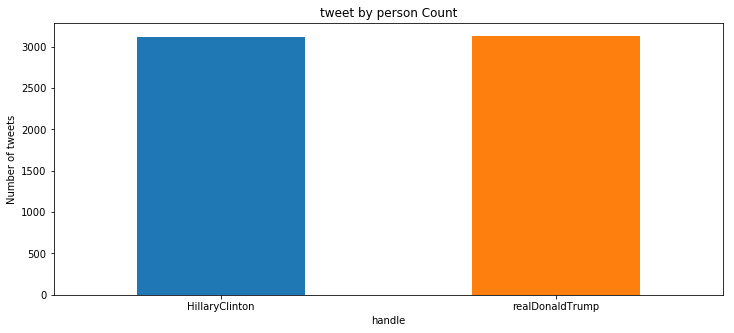

In [11]:
ax=tweets.groupby(['handle']).size().plot.bar(figsize=(12, 5),rot=0)
ax.set_title('tweet by person Count')
ax.set_ylabel('Number of tweets')

In [12]:
clintonDf=tweets[tweets['handle']=='HillaryClinton']
trumpDf=tweets[tweets['handle']=='realDonaldTrump']


In [13]:
clintonDf=clintonDf.sample(3100,random_state=500)
trumpDf=trumpDf.sample(3100,random_state=500)
tweets=pd.concat([clintonDf,trumpDf])

In [14]:
tweets.groupby(['handle']).size()

handle
HillaryClinton     3100
realDonaldTrump    3100
dtype: int64

In [15]:
tweets.columns = ['TWEETER', 'TEXT','DATE']

In [16]:
tweets.head()

TWEETER                                               TEXT  \
1068  HillaryClinton  Nearly 100 years ago, women broke down barrier...   
3668  HillaryClinton                 Thank you. https://t.co/JeMUyYFlzJ   
1685  HillaryClinton  22 memorable moments from the Democratic Conve...   
3383  HillaryClinton  Donald Trump launched his campaign one year ag...   
602   HillaryClinton  "Donald Trump says stuff every day that used t...   

                    DATE  
1068 2016-08-26 18:55:26  
3668 2016-06-08 03:07:12  
1685 2016-08-03 02:30:03  
3383 2016-06-18 20:57:24  
602  2016-09-13 18:39:10

# Exploratory Data Analysis+Feature Engineering

**1.Added time features for analyzing (derived from DATE column)-** <br> 
MONTH-represents tweet month<br> 
HOUR-represents tweet hour<br> 
**2.Added DAYS_BEFORE_ELECTIONS feature -** represents days before election <br> 
**3.Added TWEET_LENGTH feature -** represents tweet length <br> 


In [17]:
tweets.TWEETER=tweets.TWEETER.apply(lambda x: "CLINTON" if x=="HillaryClinton"  else "TRUMP")

In [18]:
tweets.describe()

TWEETER                       TEXT                 DATE
count     6200                       6200                 6200
unique       2                       6190                 6199
top      TRUMP  MAKE AMERICA GREAT AGAIN!  2016-01-14 05:45:41
freq      3100                          8                    2
first      NaN                        NaN  2016-01-05 03:36:53
last       NaN                        NaN  2016-09-28 00:22:34

In [19]:
tweets["TWEET_LENGTH"]=tweets["TEXT"].apply(lambda x:len(x)) 

In [20]:
tweets.head(5)

TWEETER                                               TEXT  \
1068  CLINTON  Nearly 100 years ago, women broke down barrier...   
3668  CLINTON                 Thank you. https://t.co/JeMUyYFlzJ   
1685  CLINTON  22 memorable moments from the Democratic Conve...   
3383  CLINTON  Donald Trump launched his campaign one year ag...   
602   CLINTON  "Donald Trump says stuff every day that used t...   

                    DATE  TWEET_LENGTH  
1068 2016-08-26 18:55:26           139  
3668 2016-06-08 03:07:12            34  
1685 2016-08-03 02:30:03           125  
3383 2016-06-18 20:57:24           109  
602  2016-09-13 18:39:10           132

In [21]:
tweets.groupby(['TWEETER']).mean()['TWEET_LENGTH']

TWEETER
CLINTON    118.651935
TRUMP      115.259032
Name: TWEET_LENGTH, dtype: float64

In [22]:
tweets[["TWEETER","TWEET_LENGTH"]].groupby("TWEETER").describe()

TWEET_LENGTH                                                         
               count        mean        std   min    25%    50%    75%    max
TWEETER                                                                      
CLINTON       3100.0  118.651935  22.884247  24.0  108.0  126.0  136.0  148.0
TRUMP         3100.0  115.259032  28.870392  14.0   98.0  128.0  138.0  148.0

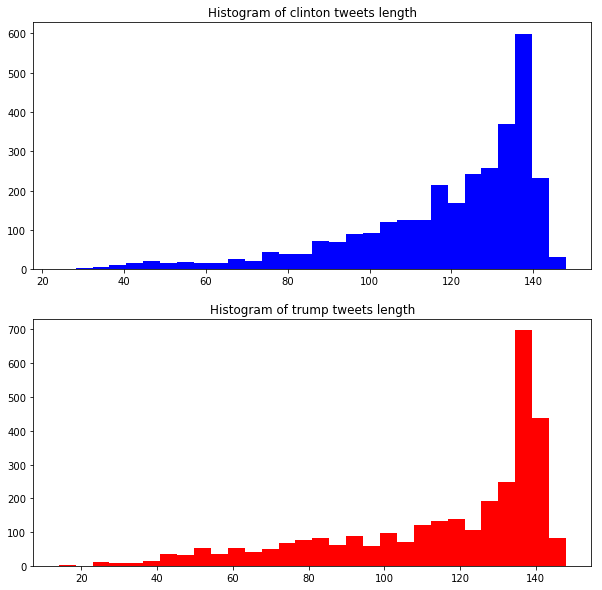

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

clintonHist=tweets[tweets["TWEETER"]=="CLINTON"].TWEET_LENGTH
hist1 = axes[0].hist(clintonHist, bins=30, color='blue')   
axes[0].set_title('Histogram of clinton tweets length')

trumpHist=tweets[tweets["TWEETER"]=="TRUMP"].TWEET_LENGTH

hist2 = axes[1].hist(trumpHist, bins=30, color='red')   
axes[1].set_title('Histogram of trump tweets length')

In [24]:
tweets["MONTH"]=tweets["DATE"].dt.month
tweets["HOUR"]=tweets["DATE"].dt.hour
tweets["DAYS_BEFORE_ELECTIONS"]=(pd.to_datetime("2016-11-08")-tweets["DATE"]).dt.days

In [25]:
tweets.head()

TWEETER                                               TEXT  \
1068  CLINTON  Nearly 100 years ago, women broke down barrier...   
3668  CLINTON                 Thank you. https://t.co/JeMUyYFlzJ   
1685  CLINTON  22 memorable moments from the Democratic Conve...   
3383  CLINTON  Donald Trump launched his campaign one year ag...   
602   CLINTON  "Donald Trump says stuff every day that used t...   

                    DATE  TWEET_LENGTH  MONTH  HOUR  DAYS_BEFORE_ELECTIONS  
1068 2016-08-26 18:55:26           139      8    18                     73  
3668 2016-06-08 03:07:12            34      6     3                    152  
1685 2016-08-03 02:30:03           125      8     2                     96  
3383 2016-06-18 20:57:24           109      6    20                    142  
602  2016-09-13 18:39:10           132      9    18                     55

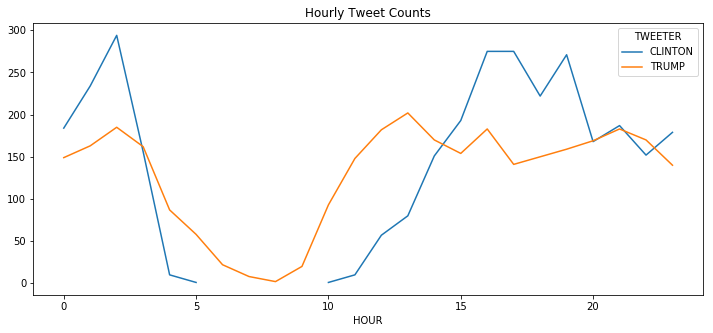

In [26]:
#Number of tweets hourly
hourly_tweets = tweets.groupby(['HOUR', 'TWEETER']).size().unstack()
hourly_tweets.plot(title='Hourly Tweet Counts',figsize=(12, 5))

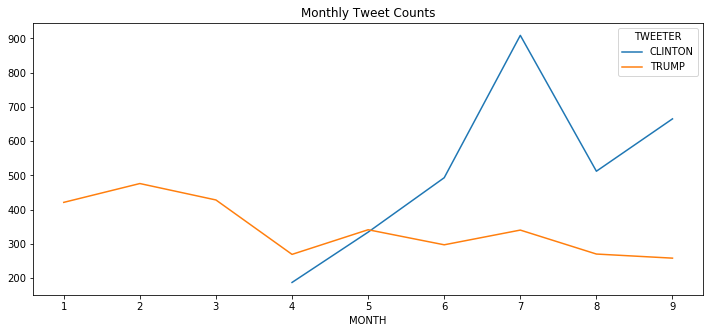

In [27]:
#Number of tweets monthly
monthly_tweets = tweets.groupby(['MONTH', 'TWEETER']).size().unstack()
monthly_tweets.plot(title='Monthly Tweet Counts',figsize=(12, 5))

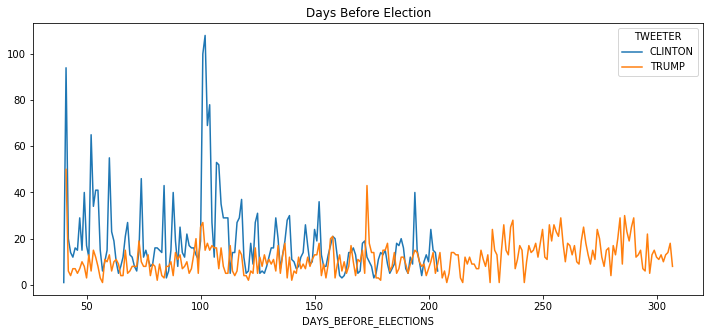

In [28]:
#Number of tweets hourly
days_before_election_tweets = tweets.groupby(['DAYS_BEFORE_ELECTIONS', 'TWEETER']).size().unstack()
days_before_election_tweets.plot(title='Days Before Election',figsize=(12, 5))

## Some Terminology

**Stemming-** is the process for reducing inflected words to their word stem (base form). 
The machine doesn’t understand the English grammar and will not differentiate the verb playing with plays, and played. So, the machine will treat all these words differently but all of these have the same meaning. 
By stemming them, it groups the frequencies of different inflections to just one term — in this case, play.

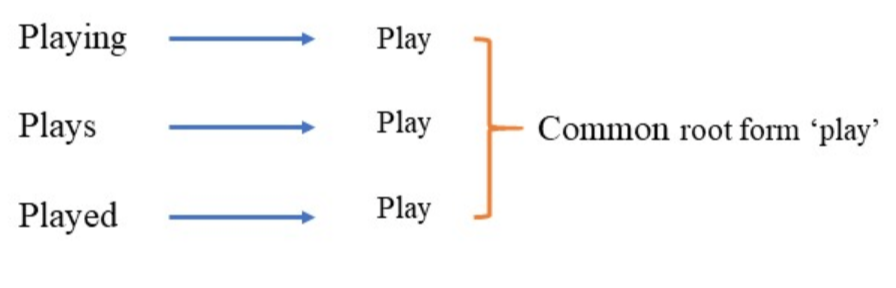

In [29]:
Image(filename='stemming.png')

**Punctuation-** are symbols or signs that indicate where pauses, stops, questions, omissions, introductions, and other forms of expression occur in our writing.

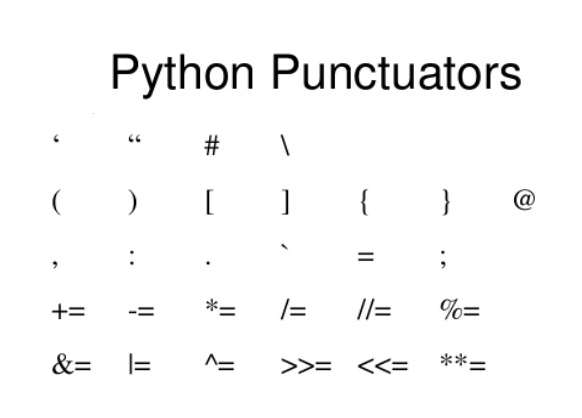

In [30]:
Image(filename='punctuation.png')

**Stop Words-** Commonly used words that are excluded from searches to help index and parse web pages faster. Some examples of stop words are: "a," "and," "but," "how," "or," and "what."

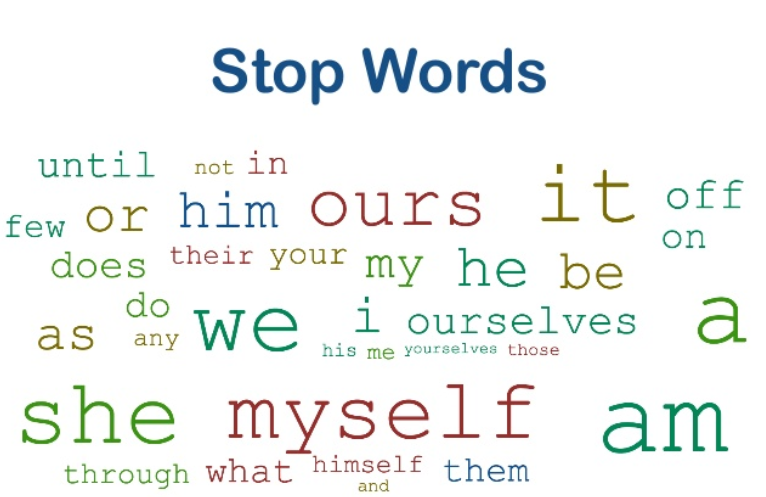

In [31]:
Image(filename='stopwords.png')


In [32]:
porter = PorterStemmer()

def stemSentence(sentence):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

In [33]:
"""
    1.Remove links (https)
    2.Remove punctuation
    3.Stem 
    4.Remove stopwords
  
    """
def cleanAndStemText(strInput):
    removedUrls=re.sub(r'https://\S+', '', strInput, flags=re.MULTILINE)
    notPuncChars = [ch for ch in removedUrls if ch not in string.punctuation]
    notPuncChars = ''.join(notPuncChars)
    stemedSentence=stemSentence(notPuncChars)

    removedStopWords=[string for string in stemedSentence.split() if string.lower() not in stopwords.words('english')]
    return removedStopWords

In [34]:
example = "It is important to be very pythonly while you are pythoning with python! \
All pythoners have pythoned poorly at least once. I learn data science with python at https://towardsdatascience.com"
cleanAndStemText(example)

['import',
 'veri',
 'pythonli',
 'python',
 'python',
 'python',
 'python',
 'poorli',
 'least',
 'onc',
 'learn',
 'data',
 'scienc',
 'python']

#  Word Cloud

**Word Cloud-** Word clouds or  are graphical representations of word frequency that give greater prominence to words that appear more frequently in a source text. The larger the word in the visual the more common the word was in the document(s)

We will create word clouds of TRUMP and CLINTON tweets
(We will filter the text with 'cleanAndStemText',in addition we will use this function in the models) 

In [35]:
tweets['TEXT_FOR_WORD_CLOAD']=tweets["TEXT"].apply(lambda x:' '.join(cleanAndStemText(x)))

In [36]:
hilaryDf=tweets[(tweets['TWEETER']=='CLINTON')]['TEXT_FOR_WORD_CLOAD']
trumpDf=tweets[(tweets['TWEETER']=='TRUMP')]['TEXT_FOR_WORD_CLOAD']

In [37]:
count = Counter(hilaryDf.str.cat().split())

print(count.most_common(10))

[('’', 678), ('trump', 644), ('”', 325), ('thi', 280), ('hillari', 264), ('hi', 252), ('make', 241), ('donald', 231), ('presid', 210), ('ha', 190)]


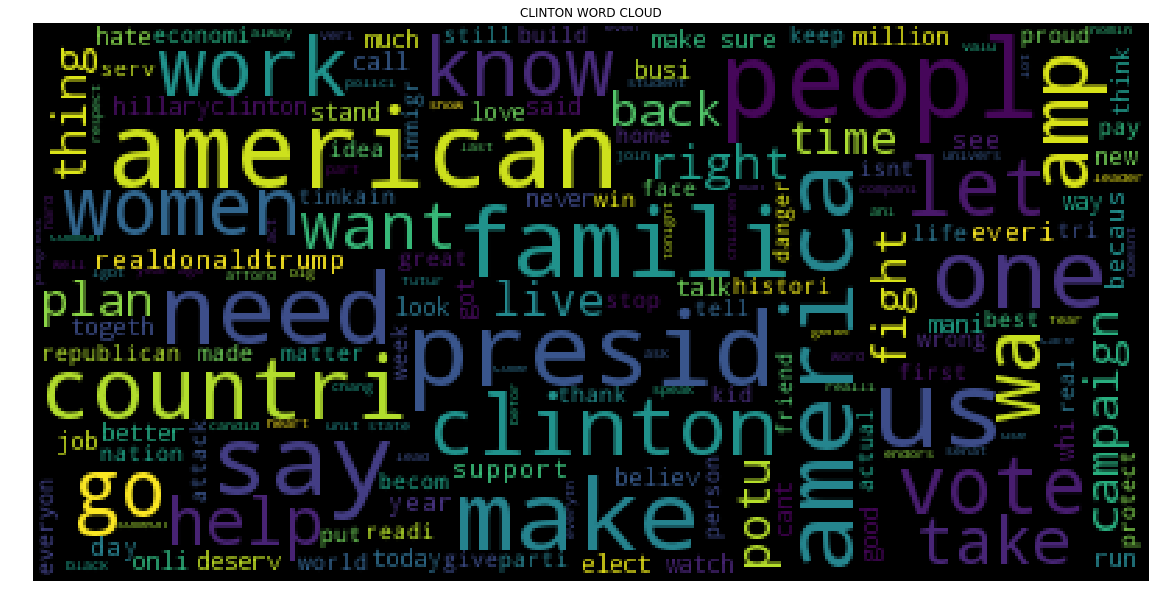

In [38]:
stopwordsToIgnore = set(STOPWORDS)
stopwordsToIgnore.add("’")
stopwordsToIgnore.add("trump")
stopwordsToIgnore.add("”")
stopwordsToIgnore.add("thi")
stopwordsToIgnore.add("hillari")
stopwordsToIgnore.add("hi")
stopwordsToIgnore.add("donald")
stopwordsToIgnore.add("ha")

hilaryWordCloud = WordCloud(max_font_size=40, relative_scaling=.5,stopwords=stopwordsToIgnore).generate(hilaryDf.str.cat())
plt.figure(figsize=(20, 20))
plt.imshow(hilaryWordCloud)
plt.axis("off")
plt.title("CLINTON WORD CLOUD")
plt.show()

In [39]:
count = Counter(trumpDf.str.cat().split())

print(count.most_common(10))

[('trump', 315), ('realdonaldtrump', 299), ('hillari', 286), ('great', 283), ('amp', 258), ('wa', 225), ('america', 199), ('ha', 195), ('peopl', 193), ('clinton', 190)]


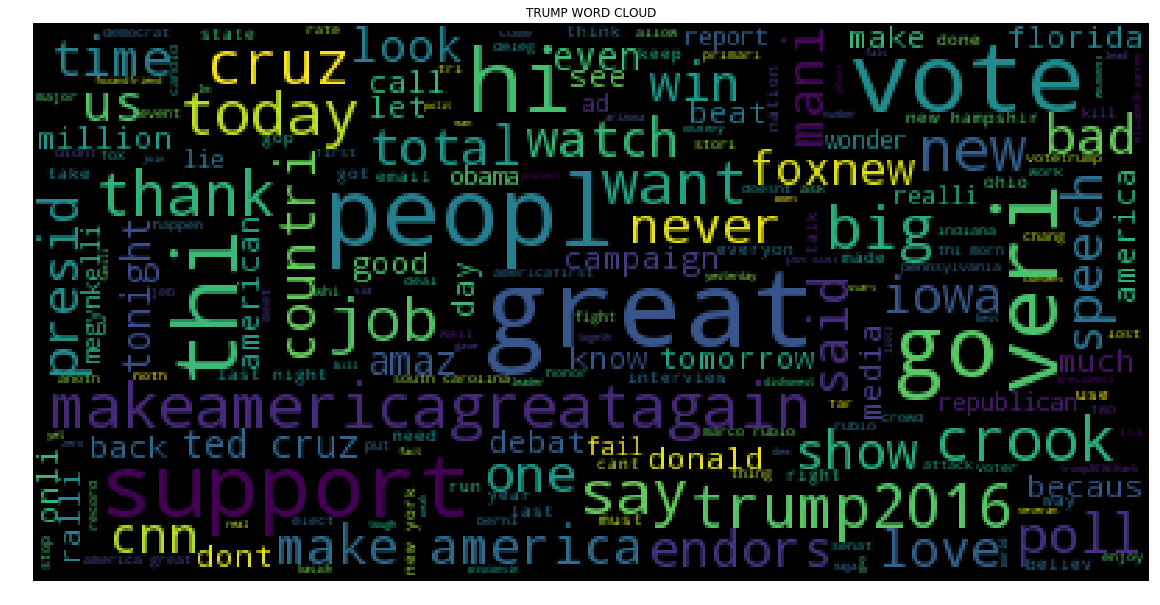

In [40]:
stopwordsToIgnore = set(STOPWORDS)
stopwordsToIgnore.add("trump")
stopwordsToIgnore.add("realdonaldtrump")
stopwordsToIgnore.add("hillari")
stopwordsToIgnore.add("amp")
stopwordsToIgnore.add("wa")
stopwordsToIgnore.add("ha")
stopwordsToIgnore.add("clinton")

trumpWordCloud = WordCloud(max_font_size=40, relative_scaling=.5,stopwords=stopwordsToIgnore).generate(trumpDf.str.cat())
plt.figure(figsize=(20, 20))
plt.imshow(trumpWordCloud)
plt.axis("off")
plt.title("TRUMP WORD CLOUD")
plt.show()

# Establish a baseline

**When comparing various machine learning algorithms, baseline provides a point of reference to compare.
We will create a naive baseline model and then try to make more complex solutions in order to get a better result.
Our baseline model will be based on the tweet length.**<br>
**Our basline models gives accuracy of 55 %**

In [41]:
y= tweets['TWEETER']
X=tweets[['TWEET_LENGTH']]
X_train,X_test,y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=500)
dt=DecisionTreeClassifier()
dt.fit(X_train,y_train)
predictions=dt.predict(X_test)
print("Running DecisionTreeClassifier algorithm for Baseline")
print("-----------------------------------------------------")
print('\n accuracy:')
print('---------------')
print(accuracy_score(y_test, predictions))
cm = confusion_matrix(y_true=y_test, y_pred=predictions)
cmDf=pd.DataFrame(cm, index=dt.classes_, columns=dt.classes_)
print('\nConfusion Matrix')
print('-------------------')
print(cmDf)
print ('\nclassification_report')
print('-------------------')
print(classification_report(y_test,predictions))

Running DecisionTreeClassifier algorithm for Baseline
-----------------------------------------------------

 accuracy:
---------------
0.558064516129

Confusion Matrix
-------------------
         CLINTON  TRUMP
CLINTON      185    122
TRUMP        152    161

classification_report
-------------------
              precision    recall  f1-score   support

     CLINTON       0.55      0.60      0.57       307
       TRUMP       0.57      0.51      0.54       313

   micro avg       0.56      0.56      0.56       620
   macro avg       0.56      0.56      0.56       620
weighted avg       0.56      0.56      0.56       620



# Compare several machine learning models with different transformations/manipulations

**Lets define 3 data manipulations/transformations modes:** <br> <br>
**Mode 1:** CountVectorizer -Convert a collection of text documents to a matrix of token counts.<br>
**steps:**
* convert text to word token counts

**Mode 2:** Using Clean data with 'cleanAndStemText' function:<br>
    1.Remove links (https)<br>
    2.Remove punctuation<br>
    3.Stem <br>
    4.Remove stopwords<br><br>
**steps:**<br>
* clean text with cleanAndStemText function
* convert text to word token counts
    
**Mode 3** -using td-idf . TF-IDF is intended to reflect how relevant a term is in a given document
in a collection or corpus.<br>
**tf-** a measure of how frequent a term is in a given document<br>
**idf-** an inverse measure of how frequent the term is in the entire corpus<br>
**steps:**
* clean text with cleanAndStemText function
* convert text to word token counts
* apply td-idf


**Choosing the best model Work Flow steps:**
* **We will run the following algorithms in diffrent modes (1,2,3):**<br>
**(MultinomialNB,KNeighborsClassifier,DecisionTreeClassifier,RandomForestClassifier,SVC,
VotingClassifier,LogisticRegression,AdaBoostClassifier,BaggingClassifier,ExtraTreesClassifier)**<br>
* **Step 1:** Compare models with mode 1 transformation.
* **Step 2:** Try to improve models with mode 2 transformation.
* **Step 3:** Try to improve models with mode 3 transformation.
* **Step 4:** From all models that give accuracy>90 % ,create models that are combinations of 3 models (create kind of manual voting classifiers of size 3).
* **Step 5:** From all models that give accuracy>90 % ,create models that are combinations of 5 models (create kind of manual voting classifiers of size 5).
* **Step 6:** Make some hyperparameter tuning from best model
* **Step 7:** The chosen model will be the one with the highest accuracy from all steps


**Pipline** <br>
We will use pipline object to store a pipeline of workflow.<br>
This will allow us to set up all the sequentially transformations on the data in an organized and elegant way.

**In our case we will have a pipline for each mode.**<br>
**Mode1:**<br>
Step 1: Vectorizing the Raw Text.<br>
Step 2: Create Model.<br>

**Mode2:**<br>
Step 1: Clean data with 'cleanAndStemText' function<br>
Step 2: Vectorizing the Raw Text.<br>
Step 3: Create Model.<br>

**Mode3:**<br>
Step 1: Clean data with 'cleanAndStemText' function<br>
Step 2: Vectorizing the Raw Text.<br>
Step 3: Td idf transformation.<br>
Step 4: Create Model.<br>



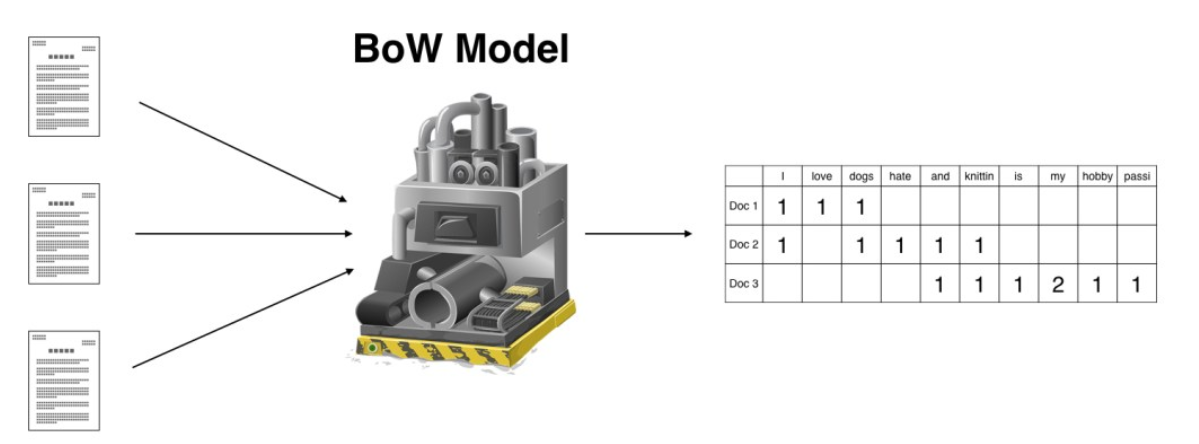

In [42]:
Image(filename='countvectorizer.png')

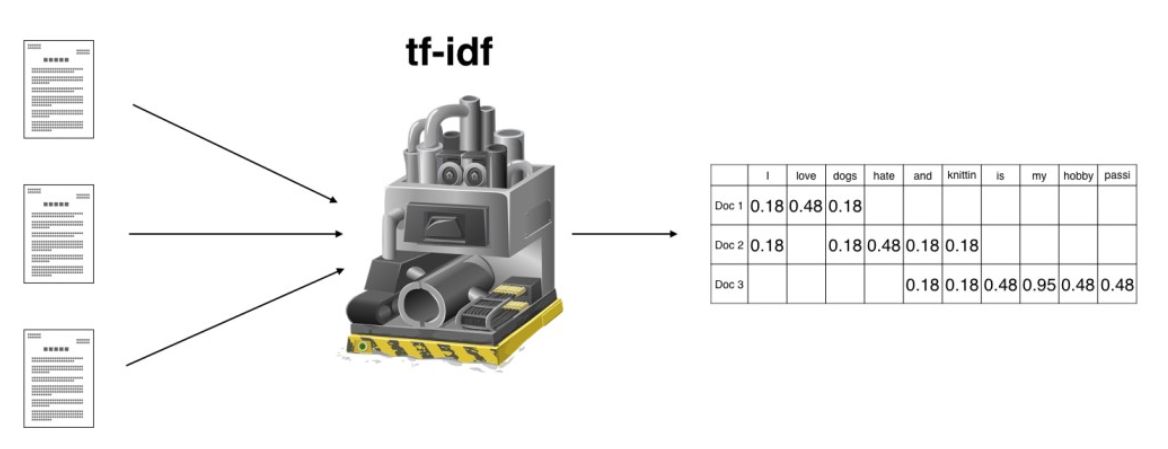

In [43]:
Image(filename='tf_idf.png')

In [44]:
"""
The function gets algorithm and mode-->return relevant pipline pipline 
 """
def initializePipelineConfiguration(algorithm,mode):
    print("Transformation Configuration:")
    print("-----------------------------")

    if(mode==1):
        print("Mode1: CountVectorizer")
        print("-----------------")
        return Pipeline([('bow', CountVectorizer()),('classifier', algorithm),])
    elif(mode==2):
        print("Mode2: CountVectorizer+Cleaning Stop Words+Stemming")
        print("----------------------------------------------")
        return Pipeline([('bow', CountVectorizer(analyzer=cleanAndStemText)),('classifier', algorithm),])
    elif(mode==3):
        print("Mode3: CountVectorizer+Cleaning text +Stemming+TfidfTransformer")
        print("----------------------------------------------------------------------")
        return Pipeline([('bow', CountVectorizer(analyzer=cleanAndStemText)), ('tfidf', TfidfTransformer()),('classifier', algorithm),])
    else:
        raise Exception("Not Supported algorithm :"+algorithmName) 

In [45]:
def getAlgorithmName(x):
    return str(x).split('(')[0]

In [46]:
res = []
"""
Function gets algorithm and mode-->Runs relevant model+mode and generates results report
 """
def runPipeLineAndPredict(algorithm,mode=3):
    algorithmName=getAlgorithmName(algorithm)
    print("Running "+ algorithmName+" algorithm")
    print("------------------------------------")
    X_train, X_test, y_train, y_test = train_test_split(tweets['TEXT'], tweets['TWEETER'], test_size=0.1, random_state=500)
    pipeline = initializePipelineConfiguration(algorithm,mode)
    pipeline.fit(X_train,y_train)
    predictions = pipeline.predict(X_test)
    print('\n accuracy:')
    print('---------------')
    acc=accuracy_score(y_test, predictions)
    print(acc)
    cm = confusion_matrix(y_test,  predictions)
    cmDf=pd.DataFrame(cm,index=pipeline.named_steps['classifier'].classes_,columns=pipeline.named_steps['classifier'].classes_)
    print('\nConfusion Matrix')
    print('-------------------')
    print(cmDf)
    print ('\nclassification_report')
    print('-------------------------')
    print(classification_report(y_test,predictions))
    res.append((acc,(algorithmName,mode)))
    print('******************************************************************************************************************')
    return acc

In [47]:

def plotResults():
    plt.style.use('fivethirtyeight')
    figsize(10, 10)

    # Dataframe to hold the results
    model_comparison = pd.DataFrame({'model': [str(element[1]) for element in res],
                                     'accuracy': [element[0] for element in res]})

    # Horizontal bar chart of test mae
    model_comparison.plot(x = 'model', y = 'accuracy', kind = 'barh', color = 'blue', edgecolor = 'black')


    # Plot formatting
    plt.ylabel('');
    plt.yticks(size = 14)
    plt.xlabel('accuracy')
    plt.xticks(size = 14)
    plt.title('Accuracy Models Comparison', size = 20)    

### Algorithms to compare

In [48]:
mnb = MultinomialNB()
knc = KNeighborsClassifier()
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier(random_state=500)
vc=VotingClassifier(estimators=[('KNN', KNeighborsClassifier()), ('NB', MultinomialNB()), ('RF', RandomForestClassifier(random_state=500))])
svc = SVC()
lrc = LogisticRegression()
abc = AdaBoostClassifier(random_state=500)
bc = BaggingClassifier(random_state=500)
etc = ExtraTreesClassifier( random_state=500)
clfs = {'_MultinomialNB': mnb,'_KNeighborsClassifier' : knc,  '_DecisionTreeClassifier': dtc,'_RandomForestClassifier': rfc,'_VotingClassifier' : vc,'_SVC': svc,'_LogisticRegression': lrc,'_AdaBoostClassifier': abc,'_BaggingClassifier': bc,'_ExtraTreesClassifier': etc}


##  Step 1: Compare models with 'mode 1' transformation.

In [49]:

pred_scores = []
for k,v in clfs.items():
    pred_scores.append((k, [runPipeLineAndPredict(v,1)]))

Running MultinomialNB algorithm
------------------------------------
Transformation Configuration:
-----------------------------
Mode1: CountVectorizer
-----------------

 accuracy:
---------------
0.922580645161

Confusion Matrix
-------------------
         CLINTON  TRUMP
CLINTON      291     16
TRUMP         32    281

classification_report
-------------------------
              precision    recall  f1-score   support

     CLINTON       0.90      0.95      0.92       307
       TRUMP       0.95      0.90      0.92       313

   micro avg       0.92      0.92      0.92       620
   macro avg       0.92      0.92      0.92       620
weighted avg       0.92      0.92      0.92       620

******************************************************************************************************************
Running KNeighborsClassifier algorithm
------------------------------------
Transformation Configuration:
-----------------------------
Mode1: CountVectorizer
-----------------

 accurac

In [50]:
df_mode1 = pd.DataFrame.from_items(pred_scores,orient='index', columns=['Mode1'])

In [51]:
res.sort(key=lambda tup: tup[0])

In [52]:
res

[(0.64838709677419359, ('SVC', 1)),
 (0.77903225806451615, ('KNeighborsClassifier', 1)),
 (0.8774193548387097, ('AdaBoostClassifier', 1)),
 (0.87903225806451613, ('ExtraTreesClassifier', 1)),
 (0.88225806451612898, ('DecisionTreeClassifier', 1)),
 (0.88225806451612898, ('RandomForestClassifier', 1)),
 (0.88548387096774195, ('BaggingClassifier', 1)),
 (0.90806451612903227, ('VotingClassifier', 1)),
 (0.92258064516129035, ('MultinomialNB', 1)),
 (0.92419354838709677, ('LogisticRegression', 1))]

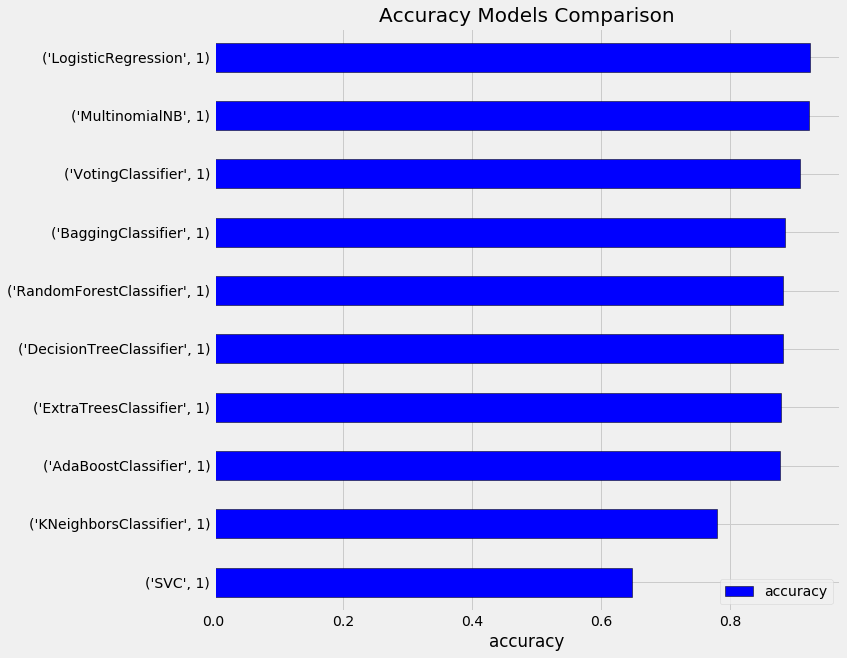

In [53]:
plotResults()

##  Step 2: Try to improve models with 'mode 2' transformation.

In [54]:
pred_scores = []
for k,v in clfs.items():
    pred_scores.append((k, [runPipeLineAndPredict(v,2)]))


Running MultinomialNB algorithm
------------------------------------
Transformation Configuration:
-----------------------------
Mode2: CountVectorizer+Cleaning Stop Words+Stemming
----------------------------------------------

 accuracy:
---------------
0.91935483871

Confusion Matrix
-------------------
         CLINTON  TRUMP
CLINTON      288     19
TRUMP         31    282

classification_report
-------------------------
              precision    recall  f1-score   support

     CLINTON       0.90      0.94      0.92       307
       TRUMP       0.94      0.90      0.92       313

   micro avg       0.92      0.92      0.92       620
   macro avg       0.92      0.92      0.92       620
weighted avg       0.92      0.92      0.92       620

******************************************************************************************************************
Running KNeighborsClassifier algorithm
------------------------------------
Transformation Configuration:
-----------------------

In [55]:
df_mode2 = pd.DataFrame.from_items(pred_scores,orient='index', columns=['Mode2'])


In [56]:
df_mode1_mode2 = pd.concat([df_mode1,df_mode2],axis=1)


In [57]:
res.sort(key=lambda tup: tup[0])

In [58]:
res

[(0.64838709677419359, ('SVC', 1)),
 (0.65161290322580645, ('SVC', 2)),
 (0.68225806451612903, ('KNeighborsClassifier', 2)),
 (0.77903225806451615, ('KNeighborsClassifier', 1)),
 (0.8403225806451613, ('AdaBoostClassifier', 2)),
 (0.87096774193548387, ('DecisionTreeClassifier', 2)),
 (0.8774193548387097, ('AdaBoostClassifier', 1)),
 (0.87903225806451613, ('ExtraTreesClassifier', 1)),
 (0.88225806451612898, ('DecisionTreeClassifier', 1)),
 (0.88225806451612898, ('RandomForestClassifier', 1)),
 (0.88387096774193552, ('RandomForestClassifier', 2)),
 (0.88548387096774195, ('BaggingClassifier', 1)),
 (0.88709677419354838, ('BaggingClassifier', 2)),
 (0.89032258064516134, ('VotingClassifier', 2)),
 (0.90645161290322585, ('ExtraTreesClassifier', 2)),
 (0.90806451612903227, ('VotingClassifier', 1)),
 (0.91935483870967738, ('MultinomialNB', 2)),
 (0.92258064516129035, ('MultinomialNB', 1)),
 (0.92419354838709677, ('LogisticRegression', 1)),
 (0.93225806451612903, ('LogisticRegression', 2))]

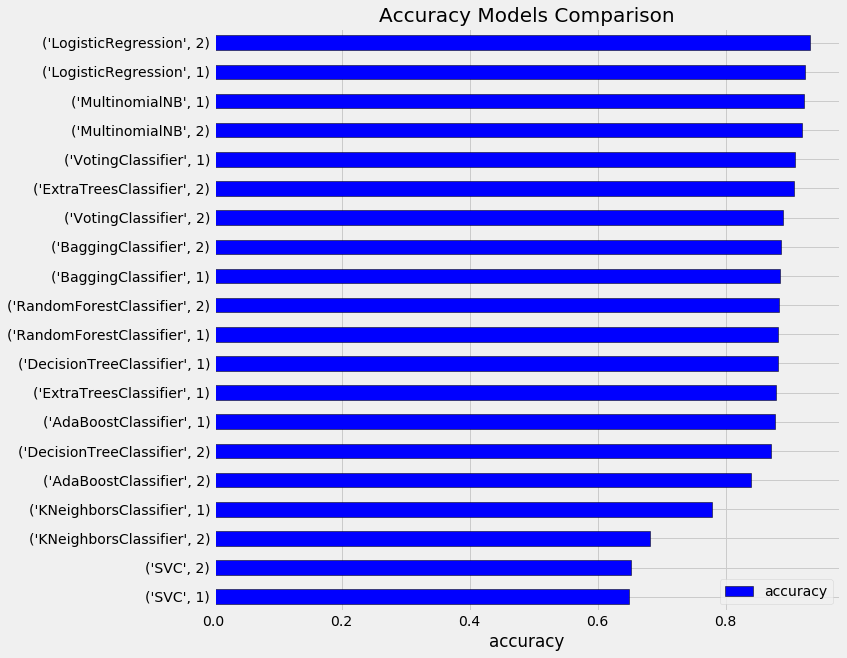

In [59]:
plotResults()

##  Step 3: Try to improve models with 'mode 3' transformation.

In [60]:
pred_scores = []
for k,v in clfs.items():
    pred_scores.append((k, [runPipeLineAndPredict(v,3)]))

Running MultinomialNB algorithm
------------------------------------
Transformation Configuration:
-----------------------------
Mode3: CountVectorizer+Cleaning text +Stemming+TfidfTransformer
----------------------------------------------------------------------

 accuracy:
---------------
0.924193548387

Confusion Matrix
-------------------
         CLINTON  TRUMP
CLINTON      292     15
TRUMP         32    281

classification_report
-------------------------
              precision    recall  f1-score   support

     CLINTON       0.90      0.95      0.93       307
       TRUMP       0.95      0.90      0.92       313

   micro avg       0.92      0.92      0.92       620
   macro avg       0.93      0.92      0.92       620
weighted avg       0.93      0.92      0.92       620

******************************************************************************************************************
Running KNeighborsClassifier algorithm
------------------------------------
Transformation C


 accuracy:
---------------
0.898387096774

Confusion Matrix
-------------------
         CLINTON  TRUMP
CLINTON      291     16
TRUMP         47    266

classification_report
-------------------------
              precision    recall  f1-score   support

     CLINTON       0.86      0.95      0.90       307
       TRUMP       0.94      0.85      0.89       313

   micro avg       0.90      0.90      0.90       620
   macro avg       0.90      0.90      0.90       620
weighted avg       0.90      0.90      0.90       620

******************************************************************************************************************


In [61]:
df_mode3 = pd.DataFrame.from_items(pred_scores,orient='index', columns=['Mode3'])

In [62]:
df = pd.concat([df_mode1_mode2,df_mode3],axis=1)

In [63]:
res.sort(key=lambda tup: tup[0])

In [64]:
res

[(0.49516129032258066, ('SVC', 3)),
 (0.64838709677419359, ('SVC', 1)),
 (0.65161290322580645, ('SVC', 2)),
 (0.68225806451612903, ('KNeighborsClassifier', 2)),
 (0.77903225806451615, ('KNeighborsClassifier', 1)),
 (0.8403225806451613, ('AdaBoostClassifier', 2)),
 (0.8403225806451613, ('AdaBoostClassifier', 3)),
 (0.84677419354838712, ('DecisionTreeClassifier', 3)),
 (0.85322580645161294, ('KNeighborsClassifier', 3)),
 (0.87096774193548387, ('DecisionTreeClassifier', 2)),
 (0.8774193548387097, ('AdaBoostClassifier', 1)),
 (0.87903225806451613, ('ExtraTreesClassifier', 1)),
 (0.88225806451612898, ('DecisionTreeClassifier', 1)),
 (0.88225806451612898, ('RandomForestClassifier', 1)),
 (0.88387096774193552, ('RandomForestClassifier', 2)),
 (0.88548387096774195, ('BaggingClassifier', 1)),
 (0.88709677419354838, ('BaggingClassifier', 2)),
 (0.88709677419354838, ('BaggingClassifier', 3)),
 (0.89032258064516134, ('VotingClassifier', 2)),
 (0.89838709677419359, ('ExtraTreesClassifier', 3)),
 (0

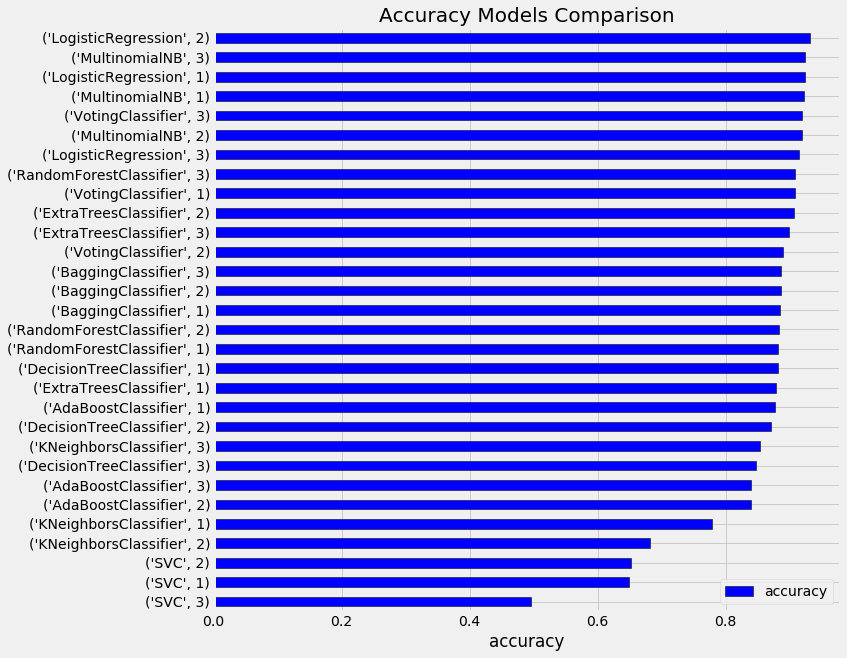

In [65]:
plotResults()

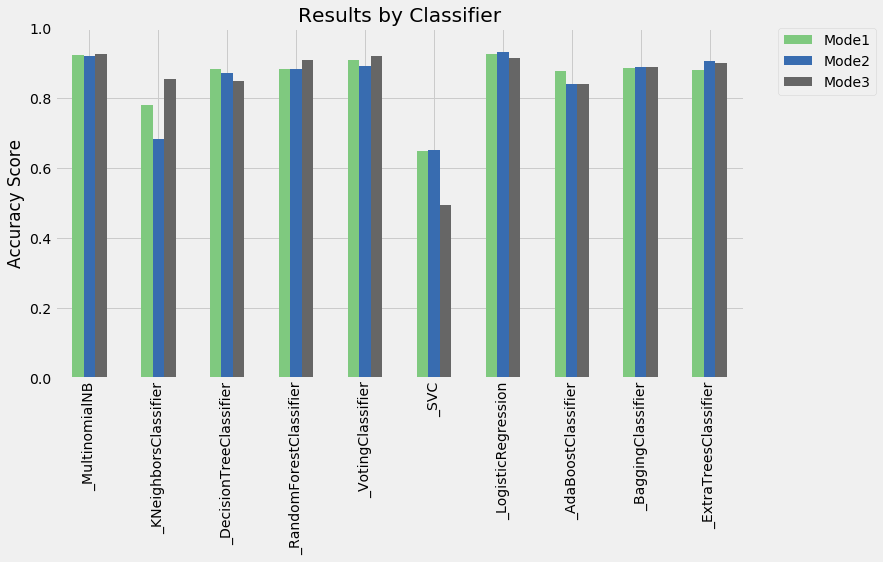

In [66]:
df.plot(kind='bar', ylim=(0,1.0), figsize=(11,6), align='center', colormap="Accent")
plt.xticks(np.arange(len(clfs)), df.index)
plt.ylabel('Accuracy Score')
plt.title('Results by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [67]:
def predictModel(algorithm,mode=3):
    X_train, X_test, y_train, y_test = train_test_split(tweets['TEXT'], tweets['TWEETER'], test_size=0.1, random_state=500)
    if(mode==1):
        pipeline=Pipeline([('bow', CountVectorizer()),('classifier', algorithm),])
    elif(mode==2):
        pipeline=Pipeline([('bow', CountVectorizer(analyzer=cleanAndStemText)),('classifier', algorithm),])
    elif(mode==3):
        pipeline=Pipeline([('bow', CountVectorizer(analyzer=cleanAndStemText)), ('tfidf', TfidfTransformer()),('classifier', algorithm),])
    else:
        raise Exception("Not Supported algorithm :"+algorithmName) 
    pipeline.fit(X_train,y_train)
    predictions = pipeline.predict(X_test)
    return predictions

In [68]:
def predict(x):
    if(sum(x=="TRUMP")>sum(x=="CLINTON")):
        return "TRUMP"
    else:
        return "CLINTON"

## Step 4: From all models that give accuracy>90 % ,choosing best mode of each algorithm and compare all combinations of size 3.
**After choosing best mode from algorithms with accuarcy>90%**
* (0.90645161290322585, ('ExtraTreesClassifier', 2)),
* (0.90806451612903227, ('RandomForestClassifier', 3)),
* (0.91935483870967738, ('VotingClassifier', 3)),
* (0.92419354838709677, ('MultinomialNB', 3)),
* (0.93225806451612903, ('LogisticRegression', 2))

**We will create models that are combinations of 3 models (kind of manual voting classifiers of pipelines).
From 5 models we can make 10 combinations of size 3.
For Each combination we will create manual voting classifiers of pipelines and try to improve accuracy**

In [69]:
over90CombinationOf3=list(combinations([(VotingClassifier(estimators=[('KNN', KNeighborsClassifier()), ('NB', MultinomialNB()), ('RF', RandomForestClassifier(random_state=500))]),3),(RandomForestClassifier(random_state=500),3),(MultinomialNB(),3),(ExtraTreesClassifier( random_state=500),2),(LogisticRegression(),2)],3))


In [70]:
over90CombinationOf3Res=[]
for x in over90CombinationOf3:
    dfPrediction = pd.DataFrame(0, index=np.arange(len(y_test)),columns=['Model1Prediction','Model2Prediction','Model3Prediction','Prediction'])
    dfPrediction["Model1Prediction"]=predictModel(x[0][0],x[0][1])
    dfPrediction["Model2Prediction"]=predictModel(x[1][0],x[1][1])
    dfPrediction["Model3Prediction"]=predictModel(x[2][0],x[2][1])
    dfPrediction['Prediction'] = dfPrediction.apply(lambda x: predict(x), axis=1)
    print("Algorithms in model:")
    print("-------------------")
    print(getAlgorithmName(x[0][0]),",Mode:",x[0][1])
    print(getAlgorithmName(x[1][0]),",Mode:",x[1][1])
    print(getAlgorithmName(x[2][0]),",Mode:",x[2][1])
    print("\n")
    print("accuracy:",accuracy_score(y_test, dfPrediction['Prediction']))
    print("\n\n")
    over90CombinationOf3Res.append((accuracy_score(y_test, dfPrediction['Prediction']),(x)))

Algorithms in model:
-------------------
VotingClassifier ,Mode: 3
RandomForestClassifier ,Mode: 3
MultinomialNB ,Mode: 3


accuracy: 0.91935483871



Algorithms in model:
-------------------
VotingClassifier ,Mode: 3
RandomForestClassifier ,Mode: 3
ExtraTreesClassifier ,Mode: 2


accuracy: 0.920967741935



Algorithms in model:
-------------------
VotingClassifier ,Mode: 3
RandomForestClassifier ,Mode: 3
LogisticRegression ,Mode: 2


accuracy: 0.93064516129



Algorithms in model:
-------------------
VotingClassifier ,Mode: 3
MultinomialNB ,Mode: 3
ExtraTreesClassifier ,Mode: 2


accuracy: 0.927419354839



Algorithms in model:
-------------------
VotingClassifier ,Mode: 3
MultinomialNB ,Mode: 3
LogisticRegression ,Mode: 2


accuracy: 0.927419354839



Algorithms in model:
-------------------
VotingClassifier ,Mode: 3
ExtraTreesClassifier ,Mode: 2
LogisticRegression ,Mode: 2


accuracy: 0.935483870968



Algorithms in model:
-------------------
RandomForestClassifier ,Mode: 3
Multinom

In [71]:
over90CombinationOf3Res.sort(key=lambda tup: tup[0],reverse=True)
bestCombinationOf3Model=over90CombinationOf3Res[0]

In [72]:
print("Best Algorithms combination of size 3:")
print("---------------------------------------")
print(getAlgorithmName(bestCombinationOf3Model[1][0][0]),",Mode:",bestCombinationOf3Model[1][0][1])
print(getAlgorithmName(bestCombinationOf3Model[1][1][0]),",Mode:",bestCombinationOf3Model[1][1][1])
print(getAlgorithmName(bestCombinationOf3Model[1][2][0]),",Mode:",bestCombinationOf3Model[1][2][1])
print()
print("accuracy:",bestCombinationOf3Model[0])


Best Algorithms combination of size 3:
---------------------------------------
RandomForestClassifier ,Mode: 3
MultinomialNB ,Mode: 3
LogisticRegression ,Mode: 2

accuracy: 0.938709677419


In [73]:
res.append((bestCombinationOf3Model[0],("Best combination of size 3","*")))

In [74]:
res.sort(key=lambda tup: tup[0])

In [75]:
res

[(0.49516129032258066, ('SVC', 3)),
 (0.64838709677419359, ('SVC', 1)),
 (0.65161290322580645, ('SVC', 2)),
 (0.68225806451612903, ('KNeighborsClassifier', 2)),
 (0.77903225806451615, ('KNeighborsClassifier', 1)),
 (0.8403225806451613, ('AdaBoostClassifier', 2)),
 (0.8403225806451613, ('AdaBoostClassifier', 3)),
 (0.84677419354838712, ('DecisionTreeClassifier', 3)),
 (0.85322580645161294, ('KNeighborsClassifier', 3)),
 (0.87096774193548387, ('DecisionTreeClassifier', 2)),
 (0.8774193548387097, ('AdaBoostClassifier', 1)),
 (0.87903225806451613, ('ExtraTreesClassifier', 1)),
 (0.88225806451612898, ('DecisionTreeClassifier', 1)),
 (0.88225806451612898, ('RandomForestClassifier', 1)),
 (0.88387096774193552, ('RandomForestClassifier', 2)),
 (0.88548387096774195, ('BaggingClassifier', 1)),
 (0.88709677419354838, ('BaggingClassifier', 2)),
 (0.88709677419354838, ('BaggingClassifier', 3)),
 (0.89032258064516134, ('VotingClassifier', 2)),
 (0.89838709677419359, ('ExtraTreesClassifier', 3)),
 (0

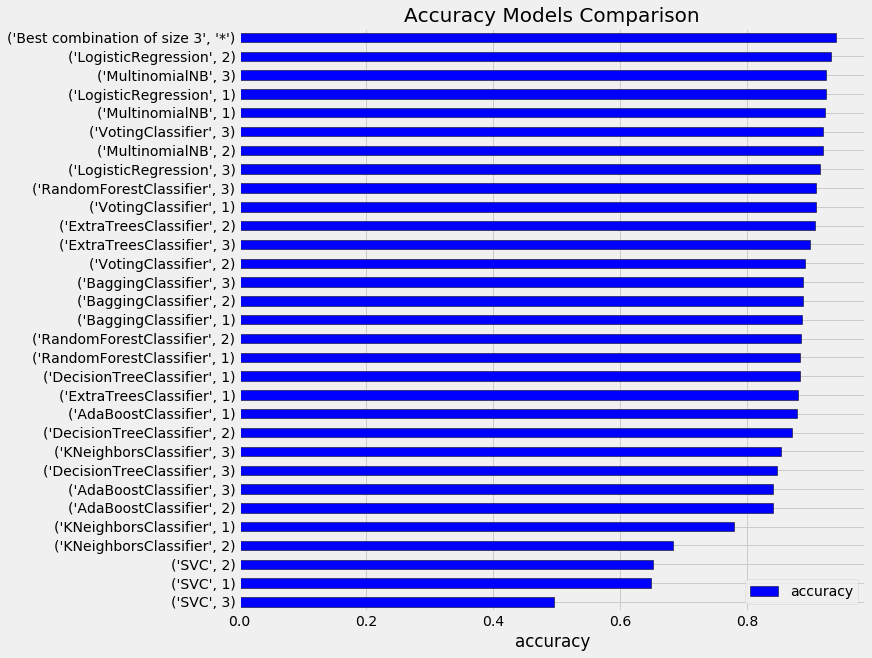

In [76]:
plotResults()

## Step 5: From all models that give accuracy>90 % ,choosing best mode of each algorithm and compare all combinations of size 5.
**After choosing best mode from algorithms with accuarcy>90%**
* (0.90645161290322585, ('ExtraTreesClassifier', 2)),
* (0.90806451612903227, ('RandomForestClassifier', 3)),
* (0.91935483870967738, ('VotingClassifier', 3)),
* (0.92419354838709677, ('MultinomialNB', 3)),
* (0.93225806451612903, ('LogisticRegression', 2))

**We will create models that are combinations of 5 models (kind of manual voting classifiers of pipelines).
From 5 models we can make 1 combinations of size 5.
For Each combination we will create manual voting classifiers of pipelines and try to improve accuracy**

In [77]:
over90CombinationOf5=list(combinations([(VotingClassifier(estimators=[('KNN', KNeighborsClassifier()), ('NB', MultinomialNB()), ('RF', RandomForestClassifier(random_state=500))]),3),(RandomForestClassifier(random_state=500),3),(MultinomialNB(),3),(ExtraTreesClassifier( random_state=500),2),(LogisticRegression(),2)],5))

over90CombinationOf5Res=[]
for x in over90CombinationOf5:
    dfPrediction = pd.DataFrame(0, index=np.arange(len(y_test)),columns=['Model1Prediction','Model2Prediction','Model3Prediction','Model4Prediction','Model5Prediction','Prediction'])
    dfPrediction["Model1Prediction"]=predictModel(x[0][0],x[0][1])
    dfPrediction["Model2Prediction"]=predictModel(x[1][0],x[1][1])
    dfPrediction["Model3Prediction"]=predictModel(x[2][0],x[2][1])
    dfPrediction["Model4Prediction"]=predictModel(x[3][0],x[3][1])
    dfPrediction["Model5Prediction"]=predictModel(x[4][0],x[4][1])
    dfPrediction['Prediction'] = dfPrediction.apply(lambda x: predict(x), axis=1)
    print("Algorithms in model:")
    print("-------------------")
    print(getAlgorithmName(x[0][0]),",Mode:",x[0][1])
    print(getAlgorithmName(x[1][0]),",Mode:",x[1][1])
    print(getAlgorithmName(x[2][0]),",Mode:",x[2][1])
    print(getAlgorithmName(x[3][0]),",Mode:",x[3][1])
    print(getAlgorithmName(x[4][0]),",Mode:",x[4][1])
    print("\n")
    print("accuracy:",accuracy_score(y_test, dfPrediction['Prediction']))
    print("\n\n")
    over90CombinationOf5Res.append((accuracy_score(y_test, dfPrediction['Prediction']),(x)))

Algorithms in model:
-------------------
VotingClassifier ,Mode: 3
RandomForestClassifier ,Mode: 3
MultinomialNB ,Mode: 3
ExtraTreesClassifier ,Mode: 2
LogisticRegression ,Mode: 2


accuracy: 0.935483870968





In [78]:
over90CombinationOf5Res.sort(key=lambda tup: tup[0],reverse=True)
bestCombinationOf5Model=over90CombinationOf5Res[0]


In [79]:

print("Best Algorithms combination of size 5:")
print("---------------------------------------")
print(getAlgorithmName(bestCombinationOf5Model[1][0][0]),",Mode:",bestCombinationOf5Model[1][0][1])
print(getAlgorithmName(bestCombinationOf5Model[1][1][0]),",Mode:",bestCombinationOf5Model[1][1][1])
print(getAlgorithmName(bestCombinationOf5Model[1][2][0]),",Mode:",bestCombinationOf5Model[1][2][1])
print(getAlgorithmName(bestCombinationOf5Model[1][3][0]),",Mode:",bestCombinationOf5Model[1][3][1])
print(getAlgorithmName(bestCombinationOf5Model[1][4][0]),",Mode:",bestCombinationOf5Model[1][4][1])

print()
print("accuracy:",bestCombinationOf5Model[0])

Best Algorithms combination of size 5:
---------------------------------------
VotingClassifier ,Mode: 3
RandomForestClassifier ,Mode: 3
MultinomialNB ,Mode: 3
ExtraTreesClassifier ,Mode: 2
LogisticRegression ,Mode: 2

accuracy: 0.935483870968


In [80]:
res.append((bestCombinationOf5Model[0],("Best combination of size 5","*")))


In [81]:
res.sort(key=lambda tup: tup[0])
res



[(0.49516129032258066, ('SVC', 3)),
 (0.64838709677419359, ('SVC', 1)),
 (0.65161290322580645, ('SVC', 2)),
 (0.68225806451612903, ('KNeighborsClassifier', 2)),
 (0.77903225806451615, ('KNeighborsClassifier', 1)),
 (0.8403225806451613, ('AdaBoostClassifier', 2)),
 (0.8403225806451613, ('AdaBoostClassifier', 3)),
 (0.84677419354838712, ('DecisionTreeClassifier', 3)),
 (0.85322580645161294, ('KNeighborsClassifier', 3)),
 (0.87096774193548387, ('DecisionTreeClassifier', 2)),
 (0.8774193548387097, ('AdaBoostClassifier', 1)),
 (0.87903225806451613, ('ExtraTreesClassifier', 1)),
 (0.88225806451612898, ('DecisionTreeClassifier', 1)),
 (0.88225806451612898, ('RandomForestClassifier', 1)),
 (0.88387096774193552, ('RandomForestClassifier', 2)),
 (0.88548387096774195, ('BaggingClassifier', 1)),
 (0.88709677419354838, ('BaggingClassifier', 2)),
 (0.88709677419354838, ('BaggingClassifier', 3)),
 (0.89032258064516134, ('VotingClassifier', 2)),
 (0.89838709677419359, ('ExtraTreesClassifier', 3)),
 (0

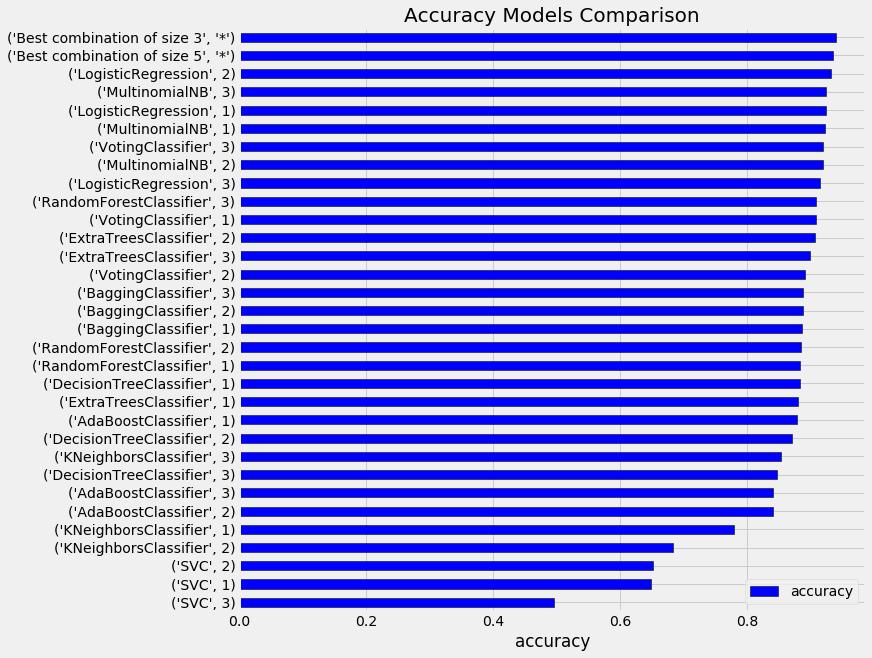

In [82]:
plotResults()

# Make some hyperparameter tuning from best combined model.


**So far,the model that gave us best accuracy:**<br>
Model combined from 3 algorithms:<br>

RandomForestClassifier ,Mode: 3<br>
MultinomialNB ,Mode: 3<br>
LogisticRegression ,Mode: 2<br>

accuracy: 0.938709677419<br>

**We will try to improve the model with hyperparameter tuning**<br>

In [83]:
X_train, X_test, y_train, y_test = train_test_split(tweets['TEXT'], tweets['TWEETER'], test_size=0.1, random_state=500)


### looking for best params for RandomForestClassifier ,Mode: 3 (Tuning - 'n_estimators' param)


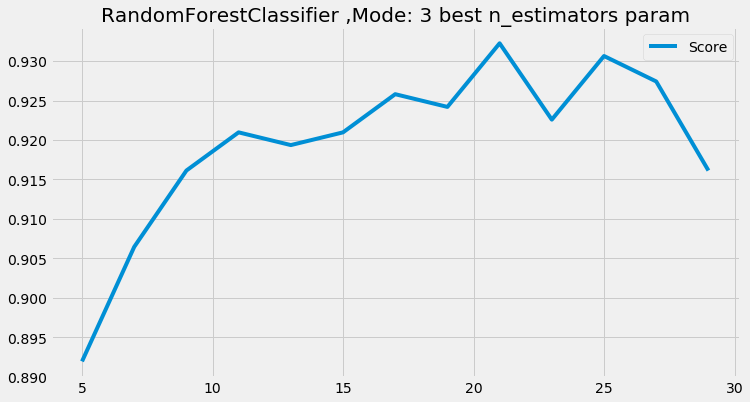

In [84]:
pred_scores = []
for i in range(5,30,2):
    rfc = Pipeline([('bow', CountVectorizer(analyzer=cleanAndStemText)), ('tfidf', TfidfTransformer()),('classifier', RandomForestClassifier(n_estimators=i,random_state=500)),])
    rfc.fit(X_train, y_train)
    pred = rfc.predict(X_test)
    acc=accuracy_score(y_test,pred)
    pred_scores.append((i, [acc]))
df = pd.DataFrame.from_items(pred_scores,orient='index', columns=['Score'])
df.plot(figsize=(11,6))
plt.title('RandomForestClassifier ,Mode: 3 best n_estimators param', size = 20)    

In [85]:
df[df['Score'] == df['Score'].max()]


Score
21  0.932258

**RandomForestClassifier ,Mode: 3, gives best accuarcy with n_estimators=21**.

### looking for best params for MultinomialNB ,Mode: 3 (Tuning - 'alpha' param)


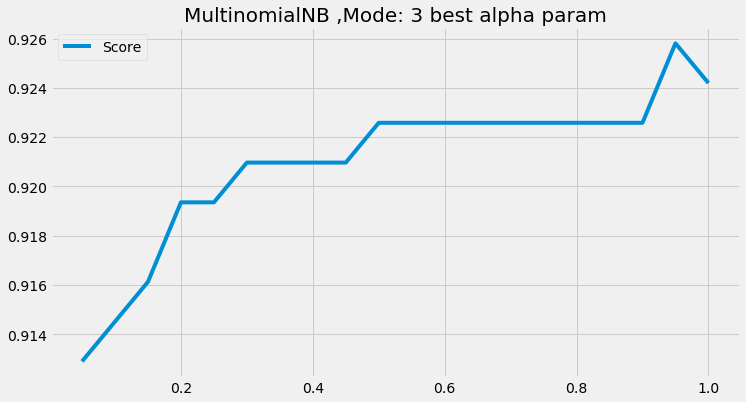

In [86]:
pred_scores = []
for i in np.linspace(0.05, 1, num=20):
    mnb = Pipeline([('bow', CountVectorizer(analyzer=cleanAndStemText)), ('tfidf', TfidfTransformer()),('classifier', MultinomialNB(alpha=i)),])
    mnb.fit(X_train, y_train)
    pred = mnb.predict(X_test)
    acc=accuracy_score(y_test,pred)
    pred_scores.append((i, [acc]))
df = pd.DataFrame.from_items(pred_scores,orient='index', columns=['Score'])
df.plot(figsize=(11,6))
plt.title('MultinomialNB ,Mode: 3 best alpha param', size = 20)    

In [87]:
df[df['Score'] == df['Score'].max()]


Score
0.95  0.925806

**MultinomialNB ,Mode: 3, gives best accuarcy with alpha=0.95**.

### looking for best params for LogisticRegression ,Mode: 2 (Tuning - 'solver' param)


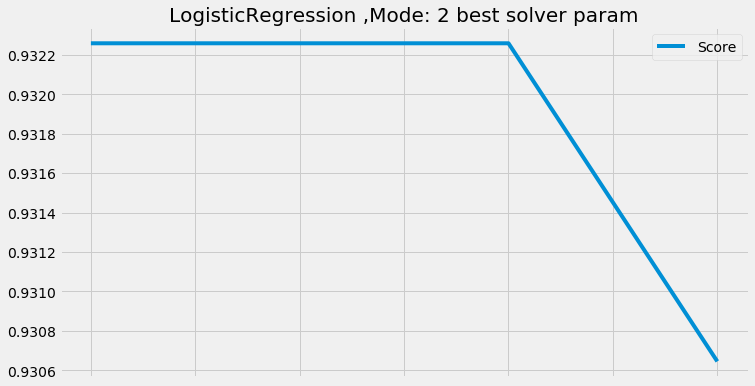

In [88]:
slvr = {'newton-cg' : 'newton-cg', 'lbfgs': 'lbfgs', 'liblinear': 'liblinear', 'sag': 'sag'}
pred_scores = []
for k,v in slvr.items():
    lr = Pipeline([('bow', CountVectorizer(analyzer=cleanAndStemText)),('classifier', LogisticRegression(solver=v, penalty='l2')),])
    lr.fit(X_train, y_train)
    pred = lr.predict(X_test)
    acc=accuracy_score(y_test,pred)
    pred_scores.append((k, [acc]))
    print()
df = pd.DataFrame.from_items(pred_scores,orient='index', columns=['Score'])
df.plot(figsize=(11,6))
plt.title('LogisticRegression ,Mode: 2 best solver param', size = 20)    

In [89]:
df[df['Score'] == df['Score'].max()]


Score
newton-cg  0.932258
lbfgs      0.932258
liblinear  0.932258

**LogisticRegression ,Mode: 2, gives best accuarcy with  default 'solver' param (liblinear)**

### Try to improve best combined model with param tuning

In [90]:
dfPrediction = pd.DataFrame(0, index=np.arange(len(y_test)),columns=['Model1Prediction','Model2Prediction','Model3Prediction','Prediction'])
dfPrediction["Model1Prediction"]=predictModel(RandomForestClassifier(n_estimators=21,random_state=500),3)
dfPrediction["Model2Prediction"]=predictModel(MultinomialNB(alpha=0.95),3)
dfPrediction["Model3Prediction"]=predictModel(LogisticRegression(),2)
dfPrediction['Prediction'] = dfPrediction.apply(lambda x: predict(x), axis=1)
print("Algorithms in model:")
print("-------------------")
print(getAlgorithmName(RandomForestClassifier(n_estimators=i,random_state=500)),",Mode:",3)
print(getAlgorithmName(MultinomialNB(alpha=i)),",Mode:",3)
print(getAlgorithmName(LogisticRegression()),",Mode:",2)
print("\n")
acc=accuracy_score(y_test, dfPrediction['Prediction'])
print("accuracy:",acc)
print("\n\n")


Algorithms in model:
-------------------
RandomForestClassifier ,Mode: 3
MultinomialNB ,Mode: 3
LogisticRegression ,Mode: 2


accuracy: 0.943548387097





In [91]:
res.append((acc,("Best combination of size 3","Param Tuning")))
res.sort(key=lambda tup: tup[0])
res

[(0.49516129032258066, ('SVC', 3)),
 (0.64838709677419359, ('SVC', 1)),
 (0.65161290322580645, ('SVC', 2)),
 (0.68225806451612903, ('KNeighborsClassifier', 2)),
 (0.77903225806451615, ('KNeighborsClassifier', 1)),
 (0.8403225806451613, ('AdaBoostClassifier', 2)),
 (0.8403225806451613, ('AdaBoostClassifier', 3)),
 (0.84677419354838712, ('DecisionTreeClassifier', 3)),
 (0.85322580645161294, ('KNeighborsClassifier', 3)),
 (0.87096774193548387, ('DecisionTreeClassifier', 2)),
 (0.8774193548387097, ('AdaBoostClassifier', 1)),
 (0.87903225806451613, ('ExtraTreesClassifier', 1)),
 (0.88225806451612898, ('DecisionTreeClassifier', 1)),
 (0.88225806451612898, ('RandomForestClassifier', 1)),
 (0.88387096774193552, ('RandomForestClassifier', 2)),
 (0.88548387096774195, ('BaggingClassifier', 1)),
 (0.88709677419354838, ('BaggingClassifier', 2)),
 (0.88709677419354838, ('BaggingClassifier', 3)),
 (0.89032258064516134, ('VotingClassifier', 2)),
 (0.89838709677419359, ('ExtraTreesClassifier', 3)),
 (0

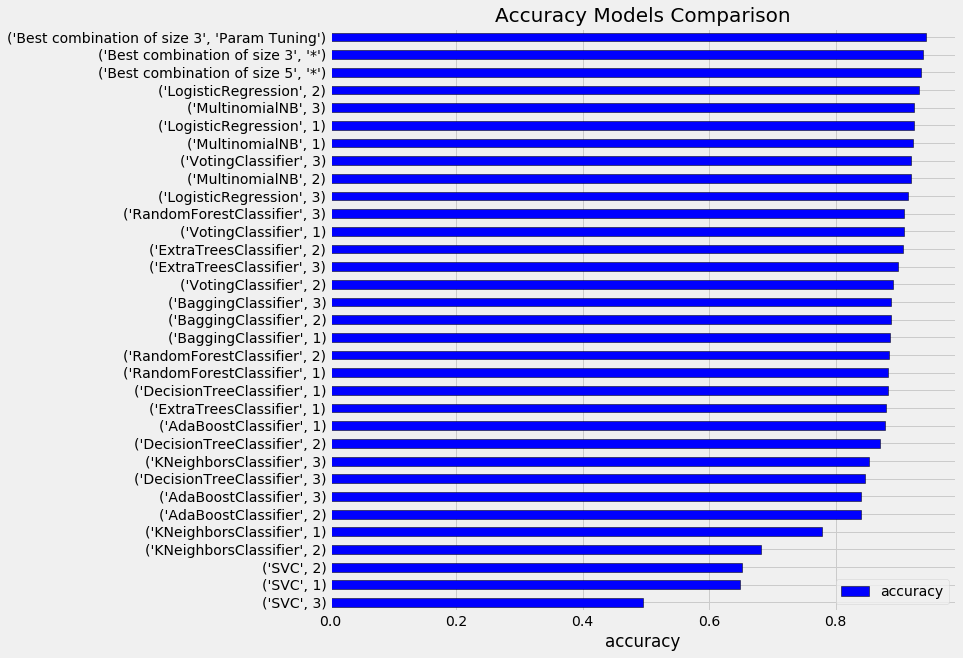

In [92]:
plotResults()


# The chosen model

**Total compared 42 models:**
* 10 models with 'mode 1'.
* 10 models algorithms with 'mode 2'.
* 10 models algorithms with 'mode 3'.
* 10 models combined with 3 models (From individual models with accuracy>90%) 
* 1 model combined with 5 models (From individual models with accuracy>90%) 
* 1 model with params tuning

**The model that gaves us best result:**<br>
**Combination of 3 models with tuning:**

**RandomForestClassifier ,Mode: 3, n_estimators=21**<br>
**MultinomialNB ,Mode: 3 ,alpha=0.95**<br>
**LogisticRegression ,Mode: 2**<br>


**accuracy: 0.94354838709677424**

# Class Implimintation of the best  algorithm 
**We will implement class of the best model that will be used as the computer guessing for the 'guess the tweeter game'**

In [93]:
class MySpecialModel(object):
    def __init__(self):
        self.model1=Pipeline([('bow', CountVectorizer(analyzer=cleanAndStemText)), ('tfidf', TfidfTransformer()),('classifier', RandomForestClassifier(n_estimators=21,random_state=500)),])
        self.model2=Pipeline([('bow', CountVectorizer(analyzer=cleanAndStemText)), ('tfidf', TfidfTransformer()),('classifier', MultinomialNB(alpha=0.95)),])
        self.model3=Pipeline([('bow', CountVectorizer(analyzer=cleanAndStemText)),('classifier', LogisticRegression()),])
    def fit(self,x_train,y_train):
        self.model1.fit(x_train,y_train)
        self.model2.fit(x_train,y_train)
        self.model3.fit(x_train,y_train)
    def predict(self,x_test):
        dfPrediction = pd.DataFrame(0, index=np.arange(len(x_test)),columns=['Model1Prediction','Model2Prediction','Model3Prediction','Prediction'])
        dfPrediction["Model1Prediction"]=self.model1.predict(x_test)
        dfPrediction["Model2Prediction"]=self.model2.predict(x_test)
        dfPrediction["Model3Prediction"]=self.model3.predict(x_test)
        dfPrediction['Prediction'] = dfPrediction.apply(lambda x: self.__predict(x), axis=1)
        return dfPrediction['Prediction']
    def __predict(self,x):
        if(sum(x=="TRUMP")>sum(x=="CLINTON")):
            return "TRUMP"
        else:
            return "CLINTON"

In [94]:
X_train, X_test, y_train, y_test = train_test_split(tweets['TEXT'], tweets['TWEETER'], test_size=0.1, random_state=500)


In [95]:
model=MySpecialModel()

In [96]:
model.fit(X_train,y_train)

In [97]:
prediction=model.predict(X_test)

In [98]:
accuracy_score(y_test, prediction)

0.94354838709677424

# Guess The Tweeter Game
**The computer will use the chosen algorithm for guessing the tweeter**

In [99]:
class GuessGameHandler(object):
    def __init__(self):
        self.rounds=0
        self.playerScore=0
        self.computerScore=0
        self.tie=0
        button = widgets.Button(description="Start")
        button.on_click(self.showQuestion)
        print("Welcome to guess the tweet game! Click start to begin:)")
        display(button)

    def showScore(self,b):
        clear_output()
        print("GAME OVER")
        print("-----------")
        print("NUMBER OF ROUNDS:",self.rounds)
        print("PLAYER SCORE:",self.playerScore)
        print("COMPUTER SCORE:",self.computerScore)
        print("NUMBER OF TIES:",self.tie)

    def showQuestion(self,b):
        clear_output()
        print("Who tweeted the following tweet?")
        print("----------------------------------")
        self.rb=widgets.RadioButtons(
        options=['TRUMP', 'CLINTON'],
        disabled=False)
        self.df_elements = tweets.sample(n=1)
        self.tweetToGuess=self.df_elements["TEXT"].iat[0]
        print(self.tweetToGuess)
        display(self.rb)
        guess = widgets.Button(description="GUESS")
        guess.on_click(self.__on_guess_button_clicked)
        display(guess)
    

    def __on_guess_button_clicked(self,b):
        clear_output()
        computerGuess=model.predict(self.df_elements["TEXT"]).iat[0]
        playerGuess=self.rb.value
        realGuess=self.df_elements['TWEETER'].iat[0]
        print("Player Result",playerGuess)
        print("Computer Result",computerGuess)
        print("Real Result",realGuess)
        self.rounds=self.rounds+1
        if(playerGuess!=computerGuess):
            if(playerGuess==realGuess):
                self.playerScore=self.playerScore+1
            if(computerGuess==realGuess):
                  self.computerScore=self.computerScore+1
        else:
            self.tie=self.tie+1
        continueBtn = widgets.Button(description="CONTINUE")
        continueBtn.on_click(self.showQuestion)
        exitBtn = widgets.Button(description="EXIT")
        exitBtn.on_click(self.showScore)
        display(widgets.HBox((continueBtn, exitBtn)))
        

In [100]:
game=GuessGameHandler()


Welcome to guess the tweet game! Click start to begin:)


Button(description='Start', style=ButtonStyle())

In [101]:
from IPython.display import HTML
import base64
import io
import os
def play(fileName):
    video = io.open(os.getcwd()+'/'+fileName, 'r+b').read()
    encoded = base64.b64encode(video)
    return(HTML(data='''<video width="320" height="240" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''.format(encoded.decode('ascii'))))

play('TrumpClintonGame.mp4')

### Some funny Error

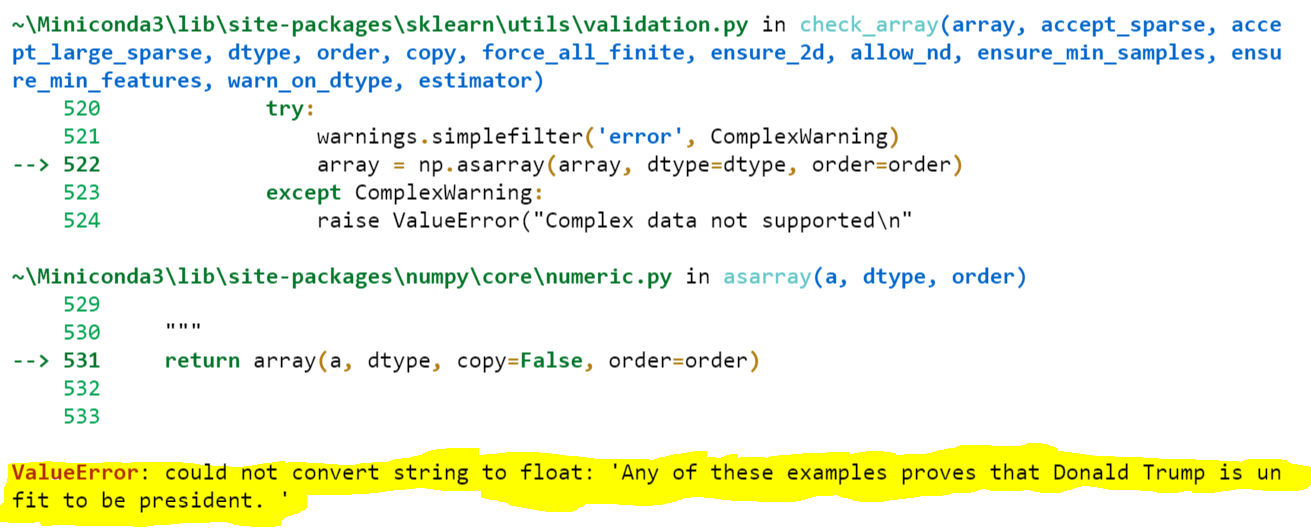

In [102]:
Image(filename='Error.png')

# Why NLP is difficult


NLP is hard for two primary reasons: humans don’t always express intent through semantically accurate language, and there are numerous ambiguities in language. Some examples include:

* **“Gabe invited me to his medical school ball”**. What is “ball” in this context?
* **"Well, I've certainly never tasted chicken cooked that way before!"** Was the chicken good or bad?
* **“jaguar”** can refer to a car or to an animal
* **“Find a block which is taller than the one you are holding and place it in the box.”** It is not clear to which word ‘it’ refers to